In [1]:
!pip install transformers -q
!pip install sentencepiece -q

     |████████████████████████████████| 3.1 MB 4.3 MB/s 
     |████████████████████████████████| 3.3 MB 21.0 MB/s 
     |████████████████████████████████| 59 kB 8.5 MB/s 
     |████████████████████████████████| 596 kB 74.2 MB/s 
     |████████████████████████████████| 895 kB 77.4 MB/s 
     |████████████████████████████████| 1.2 MB 4.3 MB/s 


In [2]:
import datetime
import os
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR
from torch.utils.data import Dataset, DataLoader, IterableDataset

from transformers import AutoModel, AutoTokenizer, AutoConfig

from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import compute_class_weight

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [3]:
from IPython.display import display, HTML

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
def get_data_loader(dataset, batch_size=16, random_seed=42):
    g = torch.Generator()
    g.manual_seed(random_seed)
    return DataLoader(dataset, batch_size=batch_size, generator=g)

In [6]:
class FusionDataset(IterableDataset):
    def __init__(self, sequences, masks, features, labels, fsize=(40,9601)):
        self.sequences = sequences
        self.masks = masks
        self.labels = labels
        self.features = features
        self.fsize = fsize
    
    def __get__(self,index):
      if self.features[index].shape[1] < self.fsize[1]:
        self.features[index] = torch.hstack((self.features[index],
                                             torch.zeros(self.fsize[0],self.fsize[1]-self.features[index].shape[1])))
      return self.features[index].reshape((1,)+self.features[index].shape)

    def __len__(self):
        return len(self.labels)

    def __iter__(self):
        for index, _ in enumerate(self.labels):
            yield self.sequences[index], self.masks[index], self.__get__(index), self.labels[index]

    def __getitem__(self, index):
        return self.sequences[index], self.masks[index], self.__get__(index), self.labels[index]

    def get_data_loader(self, batch_size=16, random_seed=42):
        return get_data_loader(self, batch_size, random_seed)
    
    @staticmethod
    def _prepare_data_(data, sequences, masks, ids, target='RagamCode', audfeature='mel_spec', fsize=(40,9601)):
      lbls = torch.tensor([data[target].iloc[x] for x in ids])
      features = [data[audfeature].iloc[x] for x in ids] # aud feature is already tensor
      return FusionDataset(sequences[ids], masks[ids], features, lbls, fsize)

    @staticmethod
    def prepare_data(data, sequences, masks, train_ids, test_ids, target='RagamCode', audfeature='mel_spec', fsize=(40,9601)):
      return FusionDataset._prepare_data_(data, sequences, masks, train_ids, target, audfeature, fsize), FusionDataset._prepare_data_(data, sequences, masks, train_ids, target, audfeature, fsize)

In [7]:
class FusionModel(nn.Module):
  def __init__(self, transformer, n_labels=2, dropout=0.1):
    super().__init__()
    self.VEC_SIZE = 768
    self.transformer = transformer
    self.aud_layer = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(1,1), padding='same'),            
            nn.ReLU(),
            nn.Conv2d(in_channels=1, out_channels=2, kernel_size=(2,2), padding='same'),            
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.AvgPool2d(kernel_size=4),
            nn.Flatten()
        )
    self.fusion = nn.Sequential(nn.Linear(48000+self.VEC_SIZE, 1000),
                                nn.ReLU(),
                                nn.Dropout(dropout),
                                nn.Linear(1000, n_labels))
  def forward(self, sequence, mask, aud):
    _, cls = self.transformer(sequence, attention_mask=mask, return_dict=False)
    aud = self.aud_layer(aud)
    x = torch.cat((aud, cls),1)
    return self.fusion(x)

In [8]:
def get_devices():
    if torch.cuda.is_available():
        gpu = torch.device("cuda")
    else:
        gpu = torch.device("cpu")
    cpu = torch.device("cpu")
    return gpu, cpu
gpu, cpu = get_devices()

In [9]:
def get_loss_function(balance_classes, labels, run_on, loss_fcn=nn.CrossEntropyLoss):
    if balance_classes:
        class_wts = compute_class_weight(class_weight='balanced',
                                         classes=np.unique(labels),
                                         y=labels
                                         )
        print(f'Class Weights : {class_wts}')
        # convert class weights to tensor
        weights = torch.tensor(class_wts, dtype=torch.float)
        weights = weights.to(run_on)
        # loss function
        loss_fcn = loss_fcn(weight=weights)
    else:
        loss_fcn = loss_fcn()
    return loss_fcn

In [10]:
def update_best_result(best_scores, valid_loss, train_labels, train_predictions, validation_labels,
                       validation_predictions,
                       model=None, model_file_name=f'saved_weights_Fold_0.pt'):
    if valid_loss < best_scores['valid_loss']:
        best_scores['valid_loss'] = valid_loss
        best_scores['train_predictions'] = train_predictions
        best_scores['validation_predictions'] = validation_predictions
        best_scores['train_labels'] = train_labels
        best_scores['validation_labels'] = validation_labels
        if model:
            torch.save(model.state_dict(), model_file_name)
    return best_scores


def update_results_dict(results, train_labels, train_predictions, validation_labels, validation_predictions,
                        average='binary', pos_label=1):
    results['train_precision'].append(precision_score(train_labels, train_predictions, average=average,
                                                      pos_label=pos_label))
    results['train_recall'].append(recall_score(train_labels, train_predictions, average=average, pos_label=pos_label))
    results['train_f1'].append(f1_score(train_labels, train_predictions, average=average, pos_label=pos_label))
    results['validation_precision'].append(precision_score(validation_labels, validation_predictions, average=average,
                                                           pos_label=pos_label))
    results['validation_recall'].append(recall_score(validation_labels, validation_predictions, average=average,
                                                     pos_label=pos_label))
    results['validation_f1'].append(
        f1_score(validation_labels, validation_predictions, average=average, pos_label=pos_label))
    results['train_labels'].append([train_labels])
    results['validation_labels'].append([validation_labels])
    results['train_predictions'].append([train_predictions])
    results['validation_predictions'].append([validation_predictions])
    return results

In [11]:
def run_model(model, dataset, loss_fcn, optimizer, is_training, run_on, clip_at=None, lstm_model=False, report_at=20):
    if is_training:
        model.train()
    else:
        model.eval()
    total_loss, total_accuracy, model_predictions, model_labels, aud_data = 0, 0, [], [], None
    for step, batch in enumerate(dataset):
        # push the batch to gpu
        batch = [r.to(run_on) for r in batch]
        sequences, masks, features, labels = batch
        if is_training:
            for o in optimizer:
                o.zero_grad()
            model.zero_grad()
            predictions = model(sequences, masks, features)
        else:
            with torch.no_grad(): 
              predictions = model(sequences, masks, features)
        # compute the loss between actual and predicted values
        loss = loss_fcn(predictions, labels)
        predictions = predictions.detach().cpu().numpy()
        total_loss = total_loss + loss.item()
        if is_training:
            loss.backward()  # backward pass to calculate the gradients
            if clip_at:
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_at)
            # update parameters
            for o in optimizer:
                o.step()
        # append the model predictions
        model_predictions.append(predictions)
        model_labels.append(labels.detach().cpu().numpy())
        del batch
    # compute the training loss of the epoch
    avg_loss = total_loss / len(dataset)
    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    model_predictions = np.concatenate(model_predictions, axis=0)
    model_labels = np.concatenate(model_labels, axis=0)
    # returns the loss and predictions
    model_predictions = np.argmax(model_predictions, axis=1)
    return avg_loss, model_predictions, model_labels

In [12]:
def plot_results(results, model_name):
    fig = plt.figure(figsize=[20, 10])
    epochs = len(results[0]['train_precision'])
    x_label = f'{len(results)} Fold and {epochs} Epochs'
    legend_labels = ['Train', 'Val']

    def subplot_routine(key1, key2, title, loss=False):
        plt.plot([x for k in results for x in results[k][key1]])
        plt.plot([x for k in results for x in results[k][key2]])
        plt.grid()
        plt.xlabel(x_label)
        plt.legend([f'{x} {title}' for x in legend_labels])
        if not loss:
            plt.ylim([0, 1.1])
        else:
            b, t = plt.ylim()
            plt.ylim(np.floor(b), np.ceil(t))

    gs = GridSpec(2, 3, figure=fig)
    plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
    subplot_routine('train_losses', 'validation_losses', 'Losses', True)
    plt.subplot(2, 3, 4)
    subplot_routine('train_precision', 'validation_precision', 'Precision')
    plt.subplot(2, 3, 5)
    subplot_routine('train_recall', 'validation_recall', 'Recall')
    plt.subplot(2, 3, 6)
    subplot_routine('train_f1', 'validation_f1', 'F1')
    plt.suptitle(f'Metrics for {model_name}')
    plt.tight_layout()
    plt.show()

In [13]:
def results_to_df(results):
    p = pd.DataFrame(results[0])
    for i in range(1, len(results)):
        p = pd.concat([p, pd.DataFrame(results[i])], axis=0)
    p.sort_values(by=['validation_f1', 'train_f1'], ascending=False, inplace=True)
    return p

In [14]:
def train_model(data, sequences, masks, transformer, gpu, **kwargs):
    start_time = datetime.datetime.now()

    n_labels = kwargs['n_labels']
    title = kwargs['title']
    random_seed = kwargs['random_seed'] if 'random_seed' in kwargs else 42
    report = kwargs['report'] if 'report' in kwargs else 20
    lstm = kwargs['lstm'] if 'lstm' in kwargs else False
    lr = kwargs['lr'] if 'lr' in kwargs else 1e-4
    clip_at = kwargs['clip_at'] if 'clip_at' in kwargs else None
    k_folds = kwargs['k_folds'] if 'k_folds' in kwargs else 5
    balance_classes = kwargs['balance_classes'] if 'balance_classes' in kwargs else True
    dropout = kwargs['dropout'] if 'dropout' in kwargs else 0.1
    plot = kwargs['plot'] if 'plot' in kwargs else True
    epochs = kwargs['epochs'] if 'epochs' in kwargs else 5
    mdlargs = kwargs['mdlargs'] if 'mdlargs' in kwargs else {}
    feature = kwargs['feature'] if 'feature' in kwargs else ['mfcc_mean']
    target = kwargs['target'] if 'target' in kwargs else 'RagamCode'
    fsize = kwargs['fsize'] if 'fsize' in kwargs else (40,9601)
    loss_fcn = kwargs['loss_fcn'] if 'loss_fcn' in kwargs else None
    model_name = kwargs['model_name'] if 'model_name' in kwargs else 'model_state.pt'
    batch_size = kwargs['batch_size'] if 'batch_size' in kwargs else 32

    torch.manual_seed(random_seed)
    k_fold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=random_seed)
    results = {x: {} for x in range(k_folds)}
    ovl_best_scores = {'valid_loss': float('inf'),
                       'train_predictions': [],
                       'validation_predictions': [],
                       'train_labels': [],
                       'validation_labels': []
                       }
    for fold, (train_ids, validation_ids) in enumerate(k_fold.split(data[feature], data[target])):
        print(f'FOLD {fold + 1} \n Data Sizes (Train/Validation) : {len(train_ids)}/{len(validation_ids)}')
        fold_start = datetime.datetime.now()
        # empty lists to store training and validation loss of each epoch
        train_losses, valid_losses = [], []
        best_scores = {'valid_loss': float('inf'),
                       'train_predictions': [],
                       'validation_predictions': [],
                       'train_labels': [],
                       'validation_labels': []
                       }
        # for each epoch
        results[fold] = {
            'train_f1': [],
            'validation_f1': [],
            'train_precision': [],
            'validation_precision': [],
            'train_recall': [],
            'validation_recall': [],
            'train_labels': [],
            'validation_labels': [],
            'train_predictions': [],
            'validation_predictions': []
        }
        train_data, validation_data = FusionDataset.prepare_data(data, sequences, masks, train_ids, validation_ids, target, feature, fsize)
        model = kwargs['model'](transformer, dropout=dropout, **mdlargs)
        model.to(gpu)
        if not loss_fcn:
            loss_fcn = get_loss_function(balance_classes, data[target].tolist(), gpu, nn.CrossEntropyLoss)
        # define the optimizer
        optimizer = [torch.optim.Adam(model.parameters(), lr=lr)]
        lr_schedulers = [ReduceLROnPlateau(optimizer[0], patience=3, factor=0.1, threshold=1e-9, mode='min'),
                         ExponentialLR(optimizer[0], gamma=0.9)]
        for epoch in range(epochs):
            e_start = datetime.datetime.now()
            # train model
            train_loss, train_predictions, train_labels = run_model(model,
                                                                    train_data.get_data_loader(batch_size=batch_size),
                                                                    loss_fcn, optimizer, run_on=gpu,
                                                                    is_training=True, clip_at=clip_at,
                                                                    lstm_model=lstm, report_at=report)
            # evaluate model
            valid_loss, validation_predictions, validation_labels = run_model(model,
                                                                              validation_data.get_data_loader(
                                                                              batch_size=batch_size),
                                                                              loss_fcn, optimizer, run_on=gpu,
                                                                              is_training=False, clip_at=clip_at,
                                                                              lstm_model=lstm, report_at=report)
            for lr_scheduler in lr_schedulers:
                lr_scheduler.step(valid_loss)
            torch.cuda.empty_cache()
            # save the best model
            best_scores = update_best_result(best_scores,
                                             valid_loss,
                                             train_labels, train_predictions,
                                             validation_labels, validation_predictions)
            ovl_best_scores = update_best_result(ovl_best_scores,
                                                 valid_loss,
                                                 train_labels, train_predictions,
                                                 validation_labels, validation_predictions,
                                                 model=model,
                                                 model_file_name=f'{model_name}')
            # append training and validation loss
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)
            results[fold] = update_results_dict(results[fold],
                                                train_labels, train_predictions,
                                                validation_labels, validation_predictions)
            e_end = datetime.datetime.now()
            print(
                f'Epoch {epoch + 1}/{epochs} : Training Loss: {train_loss:.3f} / Validation Loss : {valid_loss:.3f} [Time : {(e_end - e_start).total_seconds()} seconds]')
        print('*** Confusion Matrix - Training ***')
        print(confusion_matrix(best_scores['train_labels'], best_scores['train_predictions']))
        print('*** Confusion Matrix - Validation ***')
        print(confusion_matrix(best_scores['validation_labels'], best_scores['validation_predictions']))
        results[fold]['train_losses'] = train_losses
        results[fold]['validation_losses'] = valid_losses
        print(f'Fold {fold + 1} : {(datetime.datetime.now() - fold_start).total_seconds()} seconds')
        # To ensure CUDA is not overloaded
        del model
    end_time = datetime.datetime.now()
    print(f'Overall Time : {(end_time - start_time).total_seconds()} seconds')
    print('*** Confusion Matrix - Training ***')
    print(confusion_matrix(ovl_best_scores['train_labels'], ovl_best_scores['train_predictions']))
    print('*** Confusion Matrix - Validation ***')
    print(confusion_matrix(ovl_best_scores['validation_labels'], ovl_best_scores['validation_predictions']))
    if plot:
        plot_results(results, title)
    return results

In [16]:
data = pd.read_pickle('/content/drive/MyDrive/mp3_mfcc.pkl')
labels = torch.tensor(data['iGenre'].tolist())
txt = list(data.apply(lambda x: x.Lyric, axis=1))

In [17]:
data['iGenre'].value_counts()

1    794
0    345
Name: iGenre, dtype: int64

In [18]:
res_tbl_keys = ['train_f1','validation_f1','train_precision','validation_precision','train_recall','validation_recall']

## Indic BERT Multi Modal

In [19]:
model = AutoModel.from_pretrained('/content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin', local_files_only=True,
                                  config=AutoConfig.from_pretrained('/content/drive/MyDrive/IndicBERT_FineTuned/config.json'))
tokenizer = AutoTokenizer.from_pretrained('ai4bharat/indic-bert')
all_tokens = tokenizer.batch_encode_plus(txt, max_length=96,
                                             padding='longest',
                                             truncation=True,
                                             return_token_type_ids=False)
sequences = torch.tensor(all_tokens['input_ids'])
attention_masks = torch.tensor(all_tokens['attention_mask'])

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/507 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.38M [00:00<?, ?B/s]

FOLD 1 
 Data Sizes (Train/Validation) : 911/228
Class Weights : [1.65072464 0.71725441]
Epoch 1/5 : Training Loss: 0.900 / Validation Loss : 0.592 [Time : 15.853078 seconds]
Epoch 2/5 : Training Loss: 0.587 / Validation Loss : 0.515 [Time : 15.198574 seconds]
Epoch 3/5 : Training Loss: 0.484 / Validation Loss : 0.402 [Time : 16.06512 seconds]
Epoch 4/5 : Training Loss: 0.391 / Validation Loss : 0.320 [Time : 15.225429 seconds]
Epoch 5/5 : Training Loss: 0.350 / Validation Loss : 0.309 [Time : 15.288199 seconds]
*** Confusion Matrix - Training ***
[[240  36]
 [ 82 553]]
*** Confusion Matrix - Validation ***
[[238  38]
 [ 85 550]]
Fold 1 : 88.432725 seconds
FOLD 2 
 Data Sizes (Train/Validation) : 911/228
Epoch 1/5 : Training Loss: 0.560 / Validation Loss : 0.411 [Time : 14.445152 seconds]
Epoch 2/5 : Training Loss: 0.383 / Validation Loss : 0.349 [Time : 14.383745 seconds]
Epoch 3/5 : Training Loss: 0.340 / Validation Loss : 0.311 [Time : 14.379767 seconds]
Epoch 4/5 : Training Loss: 0

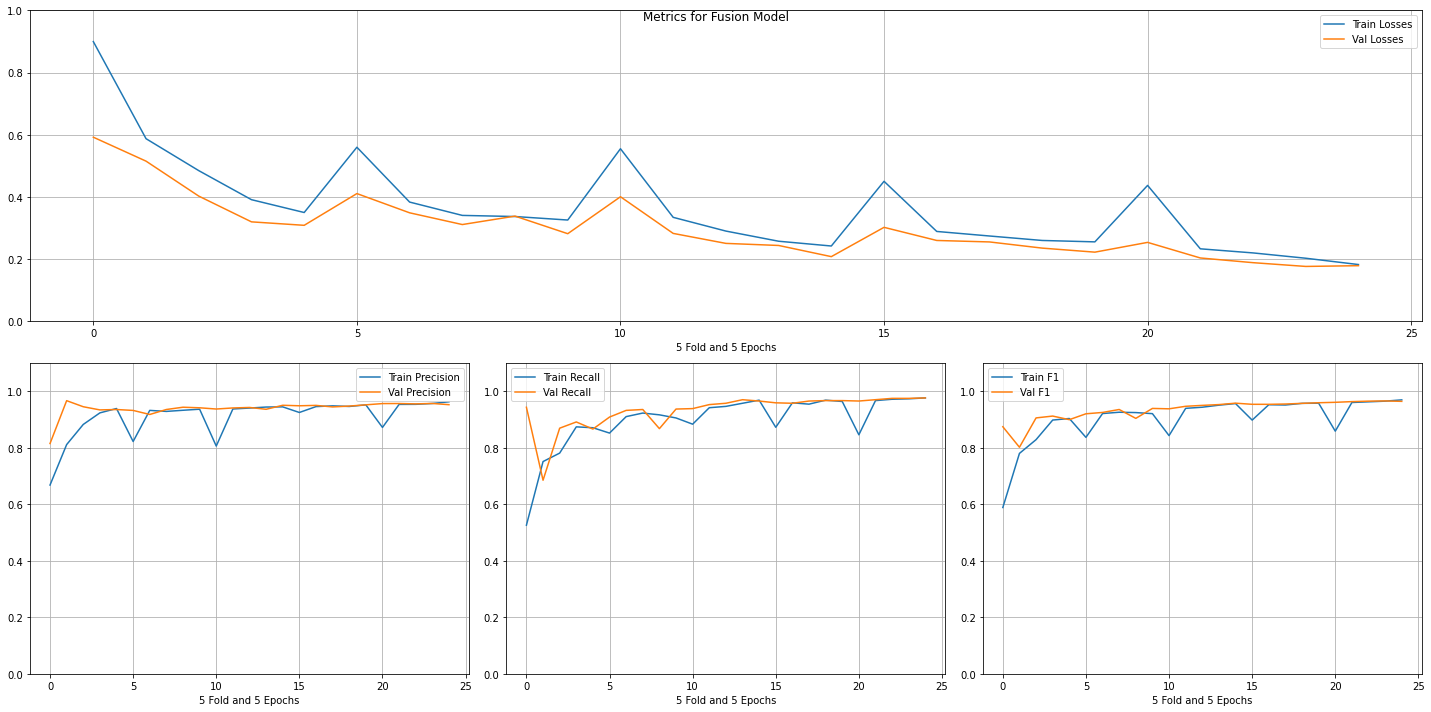

In [20]:
indic_bert_result = train_model(data, sequences, attention_masks, model, gpu, n_labels=2,feature='mfcc', title='Fusion Model',
            target='iGenre', model=FusionModel, lr=1e-5)

In [21]:
display(HTML(results_to_df(indic_bert_result)[res_tbl_keys].to_html().replace("\\n", "<br>")))

,train_f1,validation_f1,train_precision,validation_precision,train_recall,validation_recall
3,0.964926,0.965732,0.956723,0.956790,0.973270,0.974843
2,0.962617,0.964981,0.953704,0.955316,0.971698,0.974843
4,0.969555,0.964286,0.962791,0.952454,0.976415,0.976415
1,0.960187,0.963310,0.953488,0.956589,0.966981,0.970126
0,0.858739,0.960876,0.871961,0.956386,0.845912,0.965409
4,0.957746,0.959375,0.951788,0.951938,0.963780,0.966929
4,0.956454,0.957812,0.944700,0.950388,0.968504,0.965354
3,0.957198,0.957132,0.946154,0.947531,0.968504,0.966929
2,0.951334,0.954829,0.948357,0.944530,0.954331,0.965354
0,0.897893,0.953798,0.924875,0.948598,0.872441,0.959055


## MURIL Multi Modal

In [22]:
model = AutoModel.from_pretrained('/content/drive/MyDrive/MURIL_FineTuned/pytorch_model.bin', local_files_only=True,
                                  config=AutoConfig.from_pretrained('/content/drive/MyDrive/MURIL_FineTuned/config.json'))
tokenizer = AutoTokenizer.from_pretrained('google/muril-base-cased')
all_tokens = tokenizer.batch_encode_plus(txt, max_length=96,
                                             padding='longest',
                                             truncation=True,
                                             return_token_type_ids=False)
sequences = torch.tensor(all_tokens['input_ids'])
attention_masks = torch.tensor(all_tokens['attention_mask'])

Some weights of the model checkpoint at /content/drive/MyDrive/MURIL_FineTuned/pytorch_model.bin were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/181 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.02M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/113 [00:00<?, ?B/s]

FOLD 1 
 Data Sizes (Train/Validation) : 911/228
Class Weights : [1.65072464 0.71725441]
Epoch 1/5 : Training Loss: 0.918 / Validation Loss : 0.609 [Time : 20.152924 seconds]
Epoch 2/5 : Training Loss: 0.628 / Validation Loss : 0.573 [Time : 20.321037 seconds]
Epoch 3/5 : Training Loss: 0.553 / Validation Loss : 0.492 [Time : 20.206613 seconds]
Epoch 4/5 : Training Loss: 0.481 / Validation Loss : 0.384 [Time : 20.389716 seconds]
Epoch 5/5 : Training Loss: 0.397 / Validation Loss : 0.299 [Time : 20.285554 seconds]
*** Confusion Matrix - Training ***
[[229  47]
 [ 77 558]]
*** Confusion Matrix - Validation ***
[[255  21]
 [ 52 583]]
Fold 1 : 102.420691 seconds
FOLD 2 
 Data Sizes (Train/Validation) : 911/228
Epoch 1/5 : Training Loss: 0.641 / Validation Loss : 0.534 [Time : 15.638305 seconds]
Epoch 2/5 : Training Loss: 0.490 / Validation Loss : 0.401 [Time : 15.598527 seconds]
Epoch 3/5 : Training Loss: 0.395 / Validation Loss : 0.371 [Time : 15.583548 seconds]
Epoch 4/5 : Training Loss:

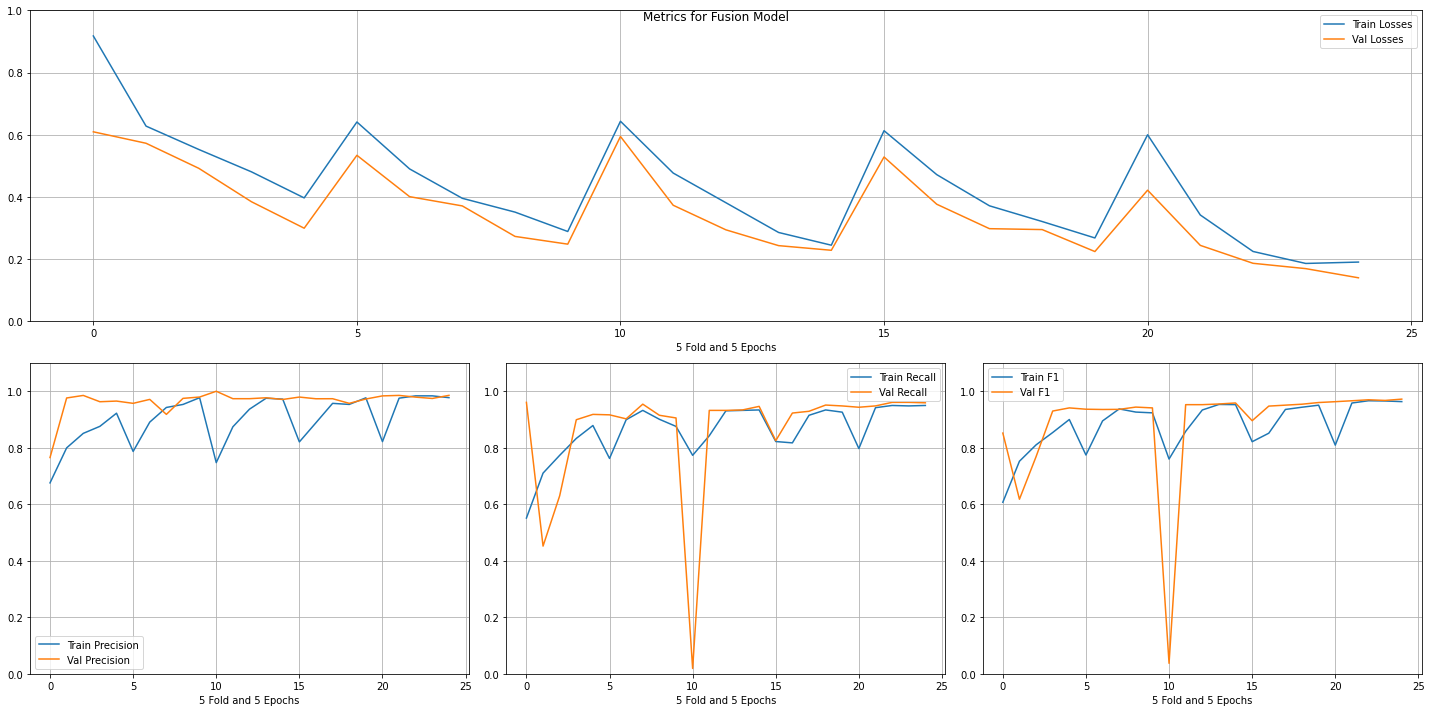

In [23]:
muril_bert_result = train_model(data, sequences, attention_masks, model, gpu, n_labels=2,feature='mfcc', title='Fusion Model',
            target='iGenre', model=FusionModel, lr=1e-5)

In [24]:
display(HTML(results_to_df(muril_bert_result)[res_tbl_keys].to_html().replace("\\n", "<br>")))

,train_f1,validation_f1,train_precision,validation_precision,train_recall,validation_recall
4,0.963317,0.972112,0.977346,0.985460,0.949686,0.959119
2,0.966400,0.969841,0.983713,0.979167,0.949686,0.960692
3,0.965572,0.967538,0.983687,0.974482,0.948113,0.960692
1,0.958400,0.966346,0.975570,0.985294,0.941824,0.948113
0,0.809258,0.963082,0.821718,0.983607,0.797170,0.943396
4,0.950687,0.960128,0.976744,0.972536,0.925984,0.948031
4,0.952610,0.958533,0.972131,0.970921,0.933858,0.946457
3,0.953301,0.954911,0.975288,0.976936,0.932283,0.933858
3,0.943516,0.954186,0.953376,0.957211,0.933858,0.951181
2,0.933649,0.952534,0.936609,0.973684,0.930709,0.932283


## XLMR Multi Modal

Some weights of the model checkpoint at /content/drive/MyDrive/XLMR_Finetuned/pytorch_model.bin were not used when initializing XLMRobertaModel: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaModel were not initialized from the model checkpoint at /content/drive/MyDrive/XLMR_Finetuned/pytorch_model.bin and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream

Downloading:   0%|          | 0.00/512 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.68M [00:00<?, ?B/s]

FOLD 1 
 Data Sizes (Train/Validation) : 911/228
Class Weights : [1.65072464 0.71725441]
Epoch 1/5 : Training Loss: 0.892 / Validation Loss : 0.558 [Time : 21.657846 seconds]
Epoch 2/5 : Training Loss: 0.558 / Validation Loss : 0.444 [Time : 21.76509 seconds]
Epoch 3/5 : Training Loss: 0.393 / Validation Loss : 0.293 [Time : 21.350619 seconds]
Epoch 4/5 : Training Loss: 0.308 / Validation Loss : 0.253 [Time : 21.403385 seconds]
Epoch 5/5 : Training Loss: 0.278 / Validation Loss : 0.223 [Time : 22.021168 seconds]
*** Confusion Matrix - Training ***
[[240  36]
 [ 41 594]]
*** Confusion Matrix - Validation ***
[[240  36]
 [ 35 600]]
Fold 1 : 109.261033 seconds
FOLD 2 
 Data Sizes (Train/Validation) : 911/228
Epoch 1/5 : Training Loss: 0.490 / Validation Loss : 0.321 [Time : 15.862352 seconds]
Epoch 2/5 : Training Loss: 0.321 / Validation Loss : 0.263 [Time : 15.905973 seconds]
Epoch 3/5 : Training Loss: 0.289 / Validation Loss : 0.252 [Time : 15.866922 seconds]
Epoch 4/5 : Training Loss: 

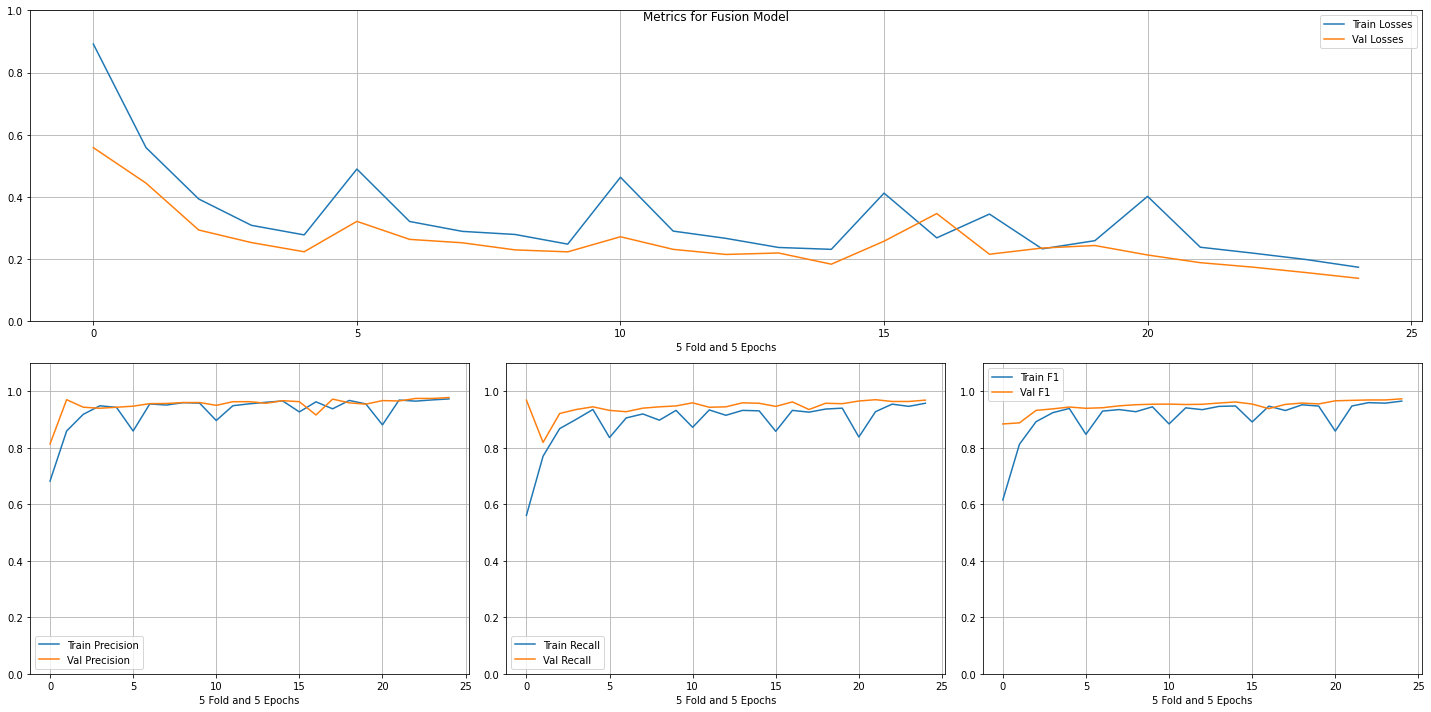

In [25]:
model = AutoModel.from_pretrained('/content/drive/MyDrive/XLMR_Finetuned/pytorch_model.bin', local_files_only=True,
                                  config=AutoConfig.from_pretrained('/content/drive/MyDrive/XLMR_Finetuned/config.json'))
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')
all_tokens = tokenizer.batch_encode_plus(txt, max_length=96,
                                             padding='longest',
                                             truncation=True,
                                             return_token_type_ids=False)
sequences = torch.tensor(all_tokens['input_ids'])
attention_masks = torch.tensor(all_tokens['attention_mask'])
xlmr_bert_result = train_model(data, sequences, attention_masks, model, gpu, n_labels=2,feature='mfcc', title='Fusion Model',
            target='iGenre', model=FusionModel, lr=1e-5)

In [26]:
display(HTML(results_to_df(xlmr_bert_result)[res_tbl_keys].to_html().replace("\\n", "<br>")))

,train_f1,validation_f1,train_precision,validation_precision,train_recall,validation_recall
4,0.965135,0.973144,0.972843,0.977778,0.957547,0.968553
2,0.959684,0.969170,0.965024,0.974563,0.954403,0.963836
3,0.957836,0.969170,0.969404,0.974563,0.946541,0.963836
1,0.947791,0.967843,0.968801,0.965571,0.927673,0.970126
0,0.858985,0.966168,0.880992,0.966929,0.838050,0.965409
4,0.947875,0.962025,0.965686,0.966614,0.930709,0.957480
3,0.946443,0.958301,0.961039,0.957547,0.932283,0.959055
3,0.952000,0.958235,0.967480,0.958991,0.937008,0.957480
4,0.947619,0.955153,0.955200,0.954403,0.940157,0.955906
0,0.891251,0.954726,0.926871,0.963141,0.858268,0.946457


## MBERT Multi Modal

Some weights of the model checkpoint at /content/drive/MyDrive/MBERT_Finetuned/pytorch_model.bin were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.87M [00:00<?, ?B/s]

FOLD 1 
 Data Sizes (Train/Validation) : 911/228
Class Weights : [1.65072464 0.71725441]
Epoch 1/5 : Training Loss: 0.767 / Validation Loss : 0.379 [Time : 18.741405 seconds]
Epoch 2/5 : Training Loss: 0.382 / Validation Loss : 0.342 [Time : 19.030112 seconds]
Epoch 3/5 : Training Loss: 0.301 / Validation Loss : 0.293 [Time : 18.747864 seconds]
Epoch 4/5 : Training Loss: 0.259 / Validation Loss : 0.238 [Time : 18.65169 seconds]
Epoch 5/5 : Training Loss: 0.213 / Validation Loss : 0.167 [Time : 18.76933 seconds]
*** Confusion Matrix - Training ***
[[251  25]
 [ 40 595]]
*** Confusion Matrix - Validation ***
[[253  23]
 [ 20 615]]
Fold 1 : 94.757413 seconds
FOLD 2 
 Data Sizes (Train/Validation) : 911/228
Epoch 1/5 : Training Loss: 0.374 / Validation Loss : 0.220 [Time : 15.285305 seconds]
Epoch 2/5 : Training Loss: 0.252 / Validation Loss : 0.168 [Time : 15.2421 seconds]
Epoch 3/5 : Training Loss: 0.197 / Validation Loss : 0.149 [Time : 18.657098 seconds]
Epoch 4/5 : Training Loss: 0.16

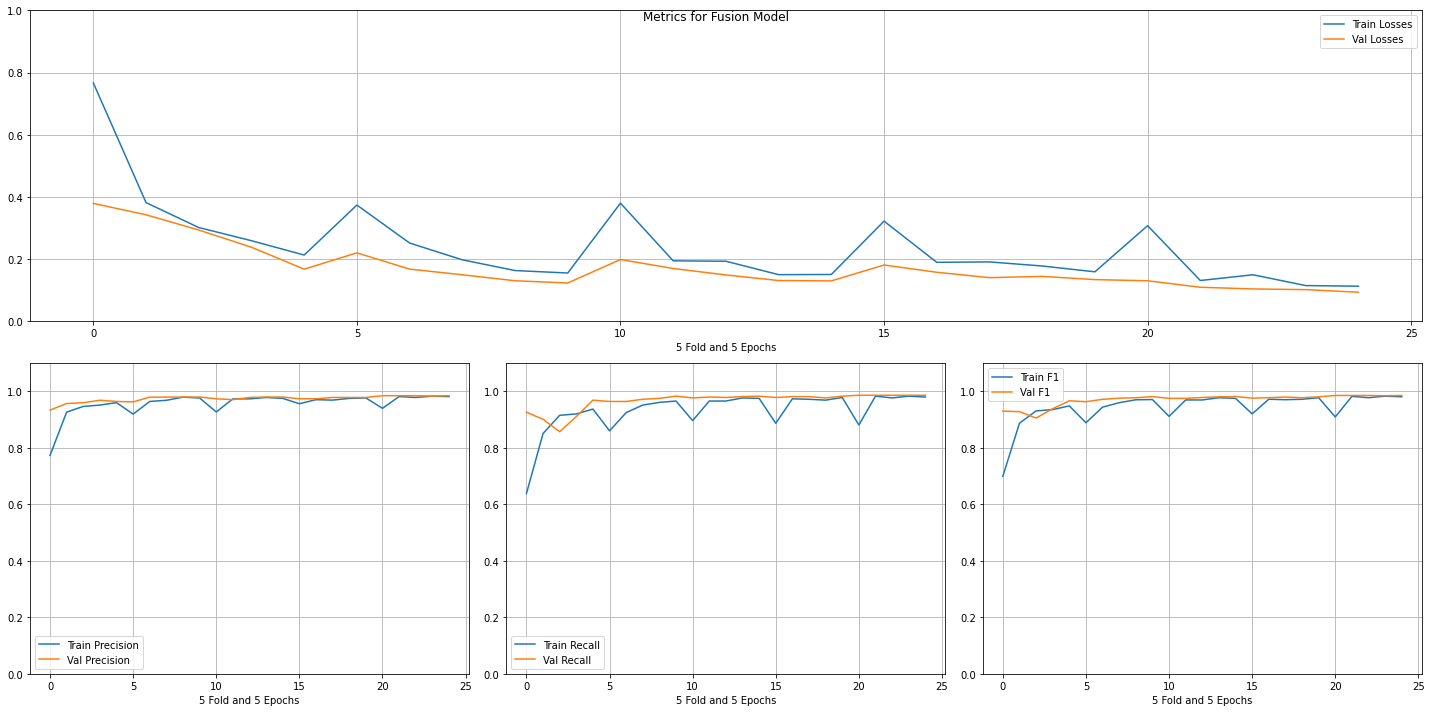

In [27]:
model = AutoModel.from_pretrained('/content/drive/MyDrive/MBERT_Finetuned/pytorch_model.bin', local_files_only=True,
                                  config=AutoConfig.from_pretrained('/content/drive/MyDrive/MBERT_Finetuned/config.json'))
tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased')
all_tokens = tokenizer.batch_encode_plus(txt, max_length=96,
                                             padding='longest',
                                             truncation=True,
                                             return_token_type_ids=False)
sequences = torch.tensor(all_tokens['input_ids'])
attention_masks = torch.tensor(all_tokens['attention_mask'])
mbert_result = train_model(data, sequences, attention_masks, model, gpu, n_labels=2,feature='mfcc', title='Fusion Model',
            target='iGenre', model=FusionModel, lr=1e-5)

In [28]:
display(HTML(results_to_df(mbert_result)[res_tbl_keys].to_html().replace("\\n", "<br>")))

,train_f1,validation_f1,train_precision,validation_precision,train_recall,validation_recall
1,0.981932,0.985075,0.981162,0.984301,0.982704,0.985849
4,0.980330,0.985075,0.981102,0.984301,0.979560,0.985849
2,0.977183,0.985075,0.977953,0.984301,0.976415,0.985849
0,0.909091,0.985075,0.939597,0.984301,0.880503,0.985849
3,0.982704,0.984301,0.982704,0.982759,0.982704,0.985849
4,0.974803,0.981132,0.974803,0.979592,0.974803,0.982677
4,0.970705,0.981132,0.976115,0.979592,0.965354,0.982677
4,0.977183,0.980361,0.976415,0.978056,0.977953,0.982677
3,0.977147,0.980330,0.977918,0.979560,0.976378,0.981102
2,0.970126,0.979560,0.968603,0.978022,0.971654,0.981102
